# Natural Disaster - NLP Use-Case: Binary Classification of Tweets

### Data Set:

The data set was downloaded from https://www.kaggle.com/competitions/nlp-getting-started/data

### Objectives

- Your clients would like to classify tweets as either being about a real disaster or not.
- They would like you to use the simplest possible model that “gets the job done” and achieves sufficiently high accuracy (a number they don’t want to define). As well, they value understanding how the model arrived at its classification, if possible.
- You will train and evaluate 3 learning algorithms of increasing complexity.
- Each learning algorithm will require preprocessing the text data differently, which you will have to implement yourself.
- Your goal is to present to your clients options that balance explainable models with performance.

### Libraries Import

In [161]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import data_viz
from collections import Counter
from wordcloud import WordCloud
import text_processor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                            confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Loading and Basic Understanding

In [162]:
df_train = pd.read_csv(r'data_set\train.csv')
df_test = pd.read_csv(r'data_set\test.csv')

print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [163]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [164]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

In [165]:
data = df_train.copy()

In [166]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [167]:
data.describe(exclude='number')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [168]:
data.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [169]:
data.duplicated().sum()

0

In [170]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [171]:
data.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [172]:
data['tweet_len'] = data.text.apply(len)
data['tweet_words_len'] = data.text.apply(lambda x: len(x.split(' ')))

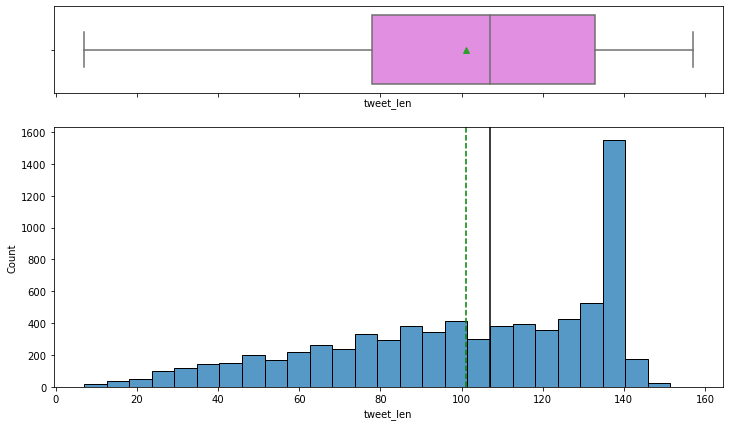

In [173]:
data_viz.histogram_boxplot(data, 'tweet_len')

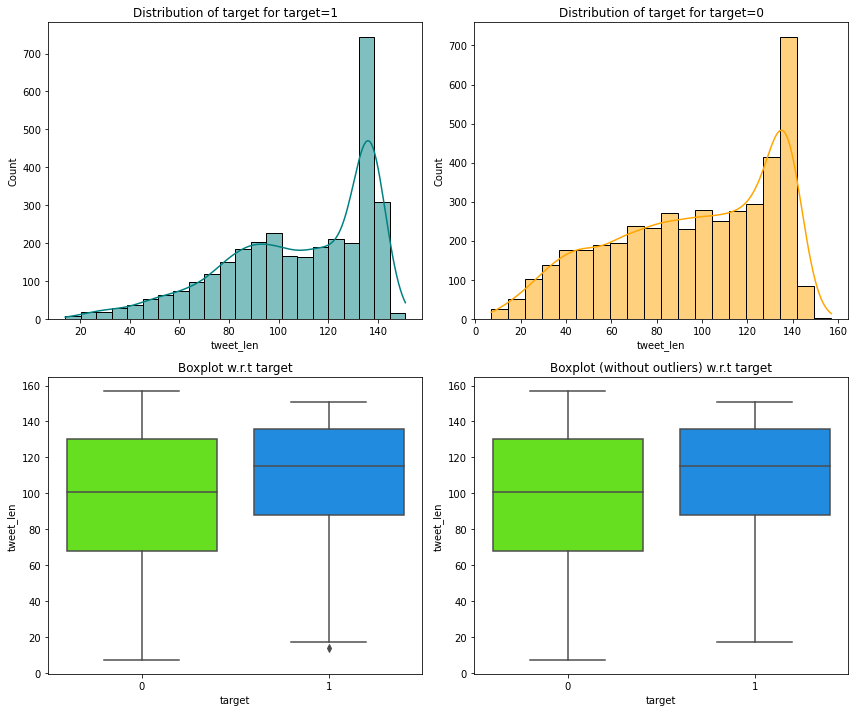

In [174]:
data_viz.distribution_plot_wrt_target(data, 'tweet_len', 'target')

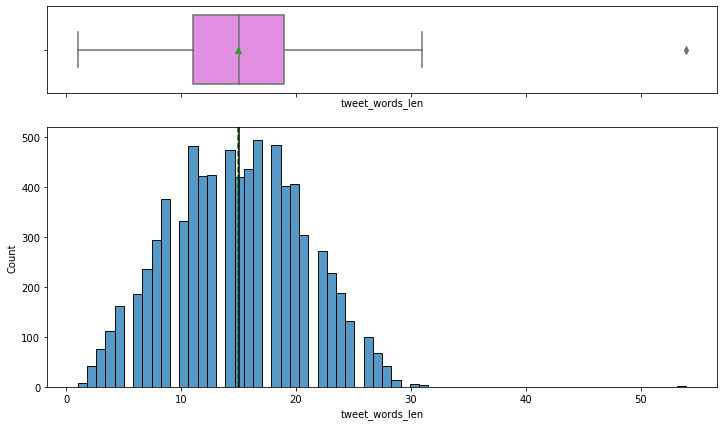

In [175]:
data_viz.histogram_boxplot(data, 'tweet_words_len')

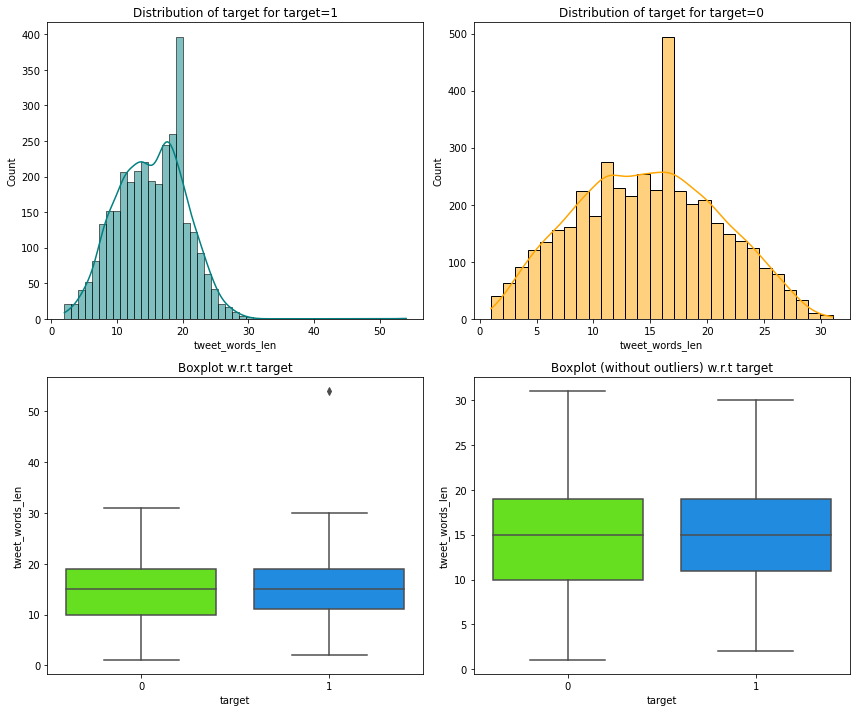

In [176]:
data_viz.distribution_plot_wrt_target(data, 'tweet_words_len', 'target')

In [177]:
data.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [178]:
text_processor.get_most_common_words(data, 'text', 'target', 10)

{'target = 1': [('the', 1051),
  ('in', 1037),
  ('of', 888),
  ('a', 730),
  ('to', 706),
  ('and', 462),
  ('-', 389),
  ('on', 386),
  ('for', 368),
  ('is', 302)],
 'target = 0': [('the', 1524),
  ('a', 1115),
  ('to', 1099),
  ('I', 938),
  ('and', 840),
  ('of', 834),
  ('in', 720),
  ('you', 529),
  ('is', 512),
  ('for', 452)]}

In [179]:
data['processed_text'] = data.text.apply(text_processor.process)

In [180]:
text_processor.get_most_common_words(data, 'processed_text', 'target', 10)

{'target = 1': [('fire', 262),
  ('news', 136),
  ('via', 121),
  ('disaster', 117),
  ('california', 115),
  ('suicide', 110),
  ('police', 107),
  ('people', 106),
  ('amp', 106),
  ('family', 105)],
 'target = 0': [('like', 255),
  ('im', 243),
  ('amp', 192),
  ('get', 185),
  ('new', 168),
  ('u', 142),
  ('dont', 141),
  ('one', 136),
  ('body', 116),
  ('time', 103)]}

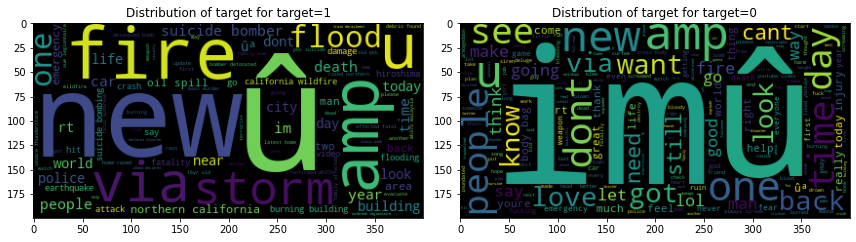

In [181]:
data_viz.display_word_cloud_by_target(data, 'processed_text', 'target')

## Data Sampling

In [182]:
X = data['processed_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"The Shape of data: {data.shape}")
print(f"The Shape of X_train: {X_train.shape}")
print(f"The Shape of X_test: {X_test.shape}")

print(f"The class distribution of data:\n{y.value_counts(normalize=True)}")
print(f"The class distribution of train data:\n{y_train.value_counts(normalize=True)}")
print(f"The class distribution of test data:\n{y_test.value_counts(normalize=True)}")

The Shape of data: (7613, 8)
The Shape of X_train: (6090,)
The Shape of X_test: (1523,)
The class distribution of data:
0    0.57034
1    0.42966
Name: target, dtype: float64
The class distribution of train data:
0    0.570279
1    0.429721
Name: target, dtype: float64
The class distribution of test data:
0    0.570584
1    0.429416
Name: target, dtype: float64


In [183]:
models = [LogisticRegression(), SGDClassifier() ,DecisionTreeClassifier(), XGBClassifier()]

In [184]:
def evaluate_performance(model, features, target):
    pred = model.predict(features)
    acc = accuracy_score(target, pred)  
    recall = recall_score(target, pred)  
    precision = precision_score(target, pred)  
    f1 = f1_score(target, pred)  

    return acc, recall, precision, f1

def compare_models_performance(models: list, features, target):
    df_perf = pd.DataFrame(columns = ["Model", "Accuracy", "Recall", "Precision", "F1"])
    for model in models:
        acc, recall, precision, f1 = evaluate_performance(model, features, target)        
        df_perf = df_perf.append({"Model":str(model).split('(')[0], "Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,}, ignore_index=True)

    return df_perf

In [185]:
def plot_conf_matrix(model, predictors, target):    
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [186]:
def plot_prec_recall_and_roc_auc(model, predictors, target):   
    try: 
        y_pred_prob = model.predict_proba(predictors)
        target_array = pd.get_dummies(target, drop_first=False).values
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        for i in range(len(target.unique())):
            fpr, tpr, thresholds = roc_curve(target_array[:,i], y_pred_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(target.unique()[i], auc(fpr, tpr)))
            ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
            ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                    xlabel='False Positive Rate', 
                    ylabel="True Positive Rate (Recall)", 
                    title="Receiver operating characteristic")
            ax[0].legend(loc="lower right")
            ax[0].grid(True)

        for i in range(len(target.unique())):
            precision, recall, thresholds = precision_recall_curve(target_array[:,i], y_pred_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(target.unique()[i],auc(recall, precision)))
            ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
                    ylabel="Precision", title="Precision-Recall curve")
            ax[1].legend(loc="best")
            ax[1].grid(True)
    except:
        print(f'no display for {str(model)}')
    finally:
        plt.show()

## Task 1: Bag of Words (bow)  

In [187]:
bow_transformer = CountVectorizer(max_features=500, preprocessor=text_processor.process, ngram_range=(1,2))

X_train_bow = bow_transformer.fit_transform(X_train)
X_test_bow = bow_transformer.transform(X_test)

print(X_train_bow.shape)
print(X_test_bow.shape)

(6090, 500)
(1523, 500)


In [188]:
for model in models:
    model.fit(X_train_bow, y_train)

In [189]:
compare_models_performance(models, X_train_bow, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.812644,0.714941,0.825684,0.766332
1,SGDClassifier,0.81642,0.714177,0.834748,0.769769
2,DecisionTreeClassifier,0.951724,0.905999,0.980157,0.94162
3,XGBClassifier,0.820525,0.676729,0.877602,0.764186


In [190]:
compare_models_performance(models, X_test_bow, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.784636,0.674312,0.793165,0.728926
1,SGDClassifier,0.786605,0.678899,0.794275,0.732069
2,DecisionTreeClassifier,0.750492,0.648318,0.738676,0.690554
3,XGBClassifier,0.788575,0.648318,0.821705,0.724786


=============================== displaying results for LogisticRegression ================================


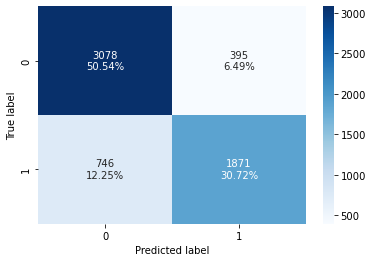

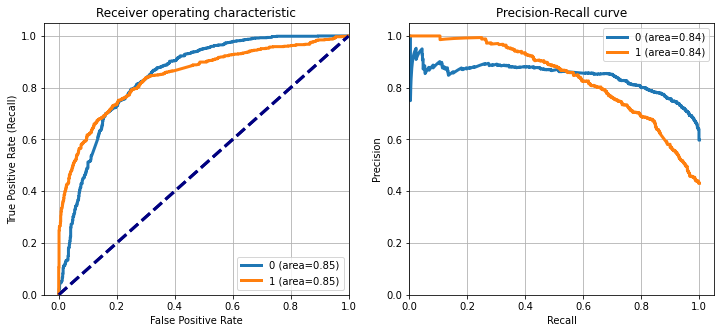

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


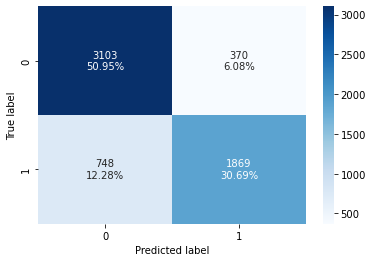

=============================== displaying results for DecisionTreeClassifier ================================


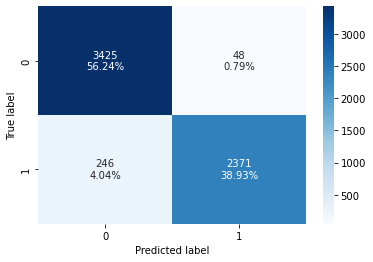

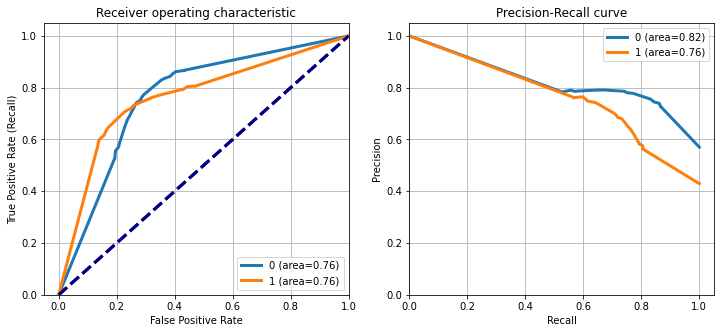

=============================== displaying results for XGBClassifier ================================


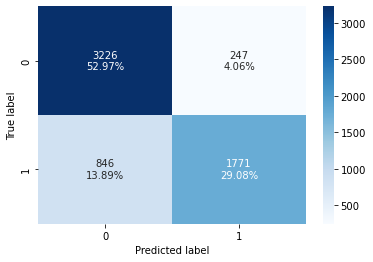

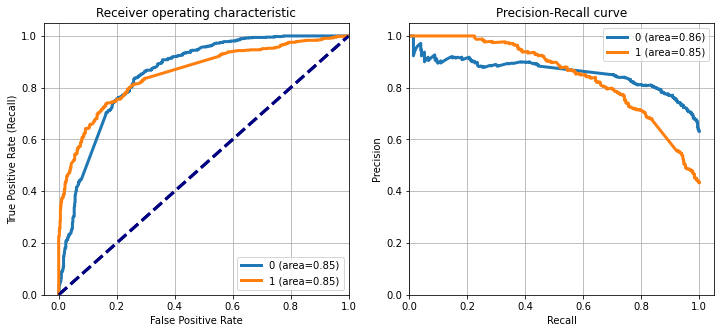

In [192]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_train_bow, y_train)
    plot_prec_recall_and_roc_auc(model, X_test_bow, y_test)

## Task 2: Feature generation and traditional ML model

In [193]:
tfidf_transformer = TfidfVectorizer(max_features=500, preprocessor=text_processor.process, ngram_range=(1,2))

X_train_tf = tfidf_transformer.fit_transform(X_train)
X_test_tf = tfidf_transformer.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(6090, 500)
(1523, 500)


In [194]:
for model in models:
    model.fit(X_train_tf, y_train)

In [195]:
compare_models_performance(models, X_train_tf, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.804269,0.699656,0.818507,0.754429
1,SGDClassifier,0.812808,0.708445,0.831017,0.764851
2,DecisionTreeClassifier,0.951396,0.904853,0.980538,0.941176
3,XGBClassifier,0.849097,0.703095,0.928355,0.800174


In [196]:
compare_models_performance(models, X_test_tf, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.789232,0.681957,0.797853,0.735367
1,SGDClassifier,0.782666,0.669725,0.792043,0.725766
2,DecisionTreeClassifier,0.740643,0.686544,0.70266,0.694509
3,XGBClassifier,0.783322,0.639144,0.816406,0.716981


=============================== displaying results for LogisticRegression ================================


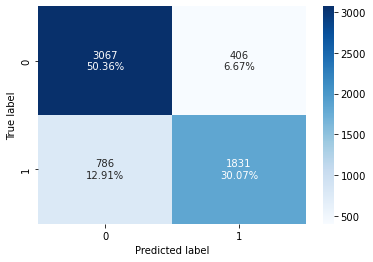

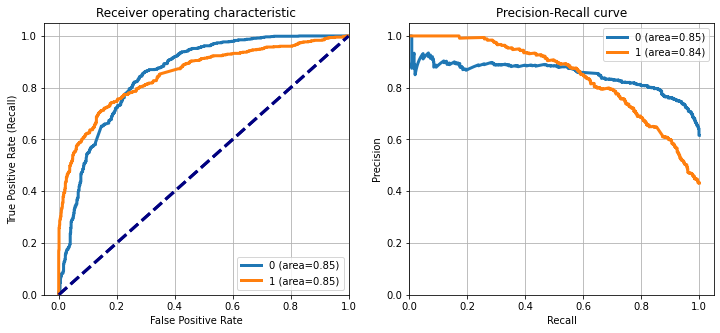

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


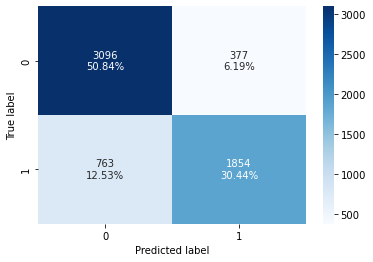

=============================== displaying results for DecisionTreeClassifier ================================


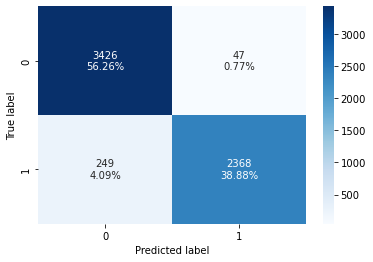

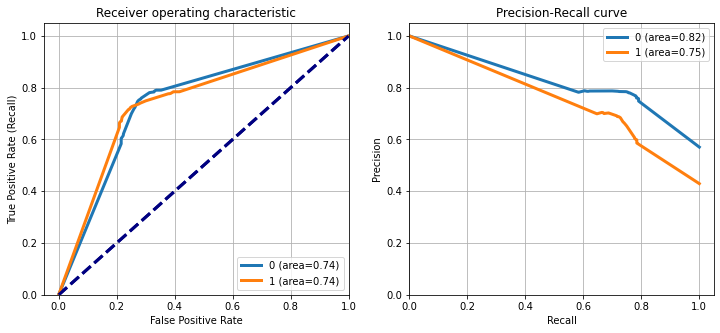

=============================== displaying results for XGBClassifier ================================


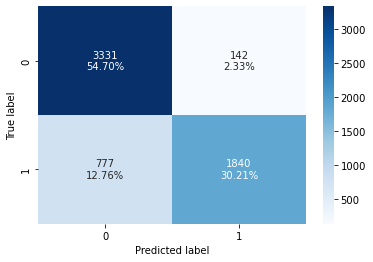

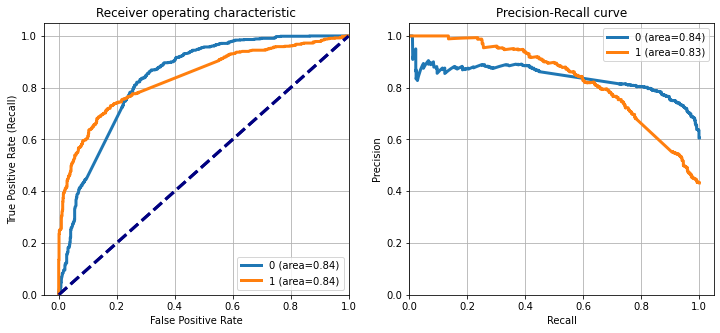

In [197]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_train_tf, y_train)
    plot_prec_recall_and_roc_auc(model, X_test_tf, y_test)

## Task 3: Pre-trained word embeddings + linear classifier model

The Glove Twitter embeddings are dwnloaded from https://nlp.stanford.edu/projects/glove/

In [100]:
embeddings_dict = {}
with open("data_set\glove.twitter.27B\glove.twitter.27B.200d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

The 200 dimensional sentence embeddings are created using a naive approach of summing the embeddings of individual words using the follwoing function

In [101]:
def get_sentence_embeddings(sentence):
    sen_embedding = np.asanyarray([0.0]*200)
    for word in sentence.split():
        if word in embeddings_dict:
            sen_embedding += embeddings_dict[word]
    
    return sen_embedding

In [103]:
X_train_glove = X_train.apply(get_sentence_embeddings).apply(pd.Series)
X_test_glove = X_test.apply(get_sentence_embeddings).apply(pd.Series)

print(X_train_glove.shape)
print(X_test_glove.shape)

(6090, 200)
(1523, 200)


In [104]:
for model in models:
    model.fit(X_train_glove, y_train)

In [105]:
compare_models_performance(models, X_train_glove, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.811823,0.718762,0.821039,0.766504
1,SGDClassifier,0.783415,0.573558,0.880869,0.694747
2,DecisionTreeClassifier,0.986207,0.971723,0.996083,0.983752
3,XGBClassifier,0.986207,0.979366,0.98843,0.983877


In [106]:
compare_models_performance(models, X_test_glove, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.80499,0.724771,0.80203,0.761446
1,SGDClassifier,0.780039,0.593272,0.849015,0.69847
2,DecisionTreeClassifier,0.697965,0.642202,0.650155,0.646154
3,XGBClassifier,0.807617,0.740061,0.797364,0.767645


=============================== displaying results for LogisticRegression ================================


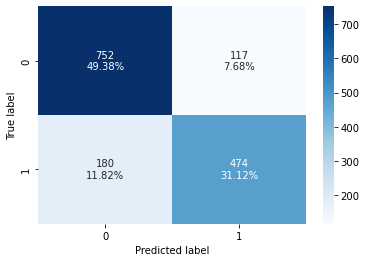

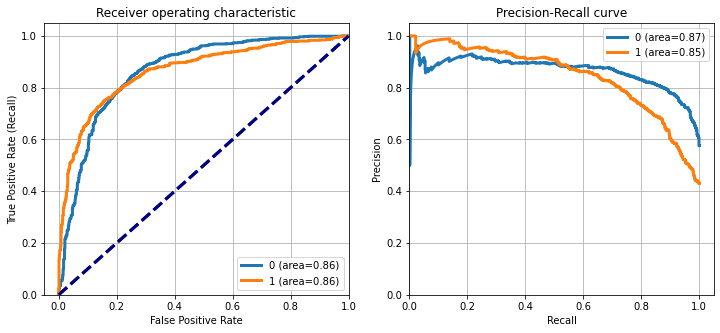

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


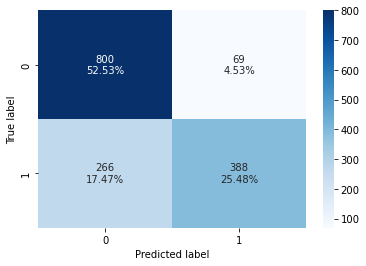

=============================== displaying results for DecisionTreeClassifier ================================


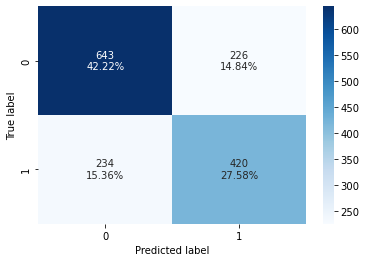

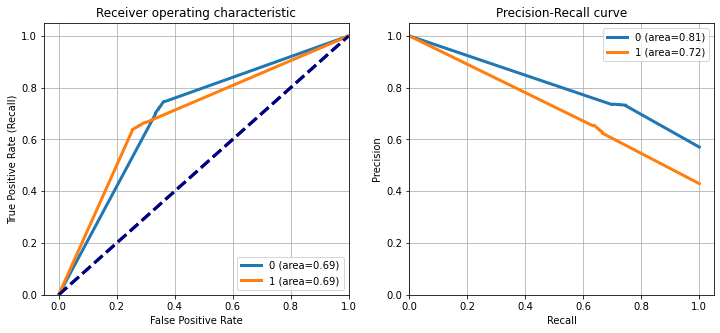

=============================== displaying results for XGBClassifier ================================


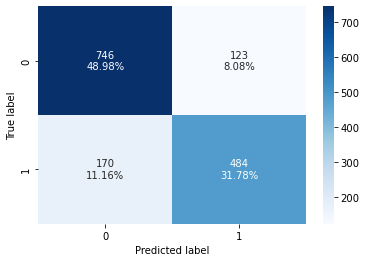

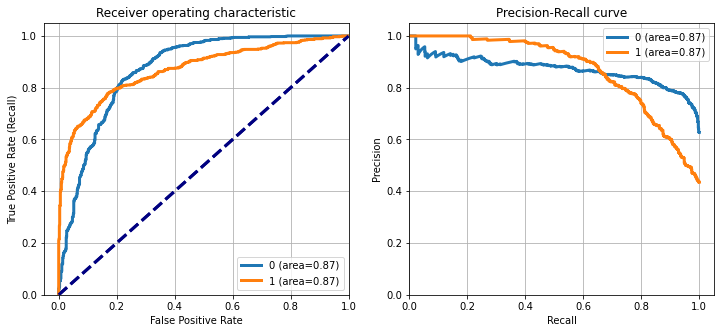

In [157]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_test_glove, y_test)
    plot_prec_recall_and_roc_auc(model, X_test_glove, y_test)

## Task 4: Recommendation to the Clients